# **MINI-PROJECT-2: Stock Price Prediction using Convolutional Neural Networks**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase"

# install import-ipynb for importing helper modules
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as gplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/P2_TimeForecast/P2_CodeBase


Define data and dnn folder paths

In [ ]:
data_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/data/"
dnn_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/dnn/"

## Load Preprocessed data

In [ ]:
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = os.path.join(data_path, "P2_Preprocessed_CNN_LSTM.csv")
df = pd.read_csv(filepath, na_values=['NA','?','-'])

print(df.dtypes , df.shape)
print()
print(df[0:5])
print()
print(df.isnull().sum())

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
Output    float64
dtype: object (4392, 6)

       Open      High       Low     Close    Volume    Output
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625

Open      0
High      0
Low       0
Close     0
Volume    0
Output    0
dtype: int64


## Spliting dataframe into features and target

In [ ]:
y = df['Output'].copy() # y is copy of close column
x = df.drop(columns=['Output'], axis= 1, inplace=False)

x = x.to_numpy(dtype="float32");
y = y.to_numpy(dtype="float32");

print(x.shape, y.shape)
print(x[0:5])
print(y[0:5])

(4392, 5) (4392,)
[[-8.9420879e-01 -8.8502169e-01 -8.9230639e-01 -8.8436353e-01
   1.1048120e+00]
 [-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
  -4.9730068e-01]
 [-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
  -8.9221716e-01]
 [-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
  -2.6340524e-04]
 [-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
   3.7293661e+00]]
[4.125    4.015625 4.       3.84375  3.390625]


## Converting array into 4D array for CNN using to_sequence()

In [ ]:
import numpy as np

def to_sequences(seq_size, input, target):
    x = []
    y = []

    for i in range(len(target)-seq_size-1):
        window = input[i:(i+seq_size)]
        after_window = target[i+seq_size]
        window = [x for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [ ]:
# each record is converted into 7X5 array
SEQ_SIZE = 7
x,y = to_sequences(SEQ_SIZE, x, y)
print(x.shape , y.shape)
print(x[0:2])
print(y[0:2])

(4384, 7, 5) (4384,)
[[[-8.9420879e-01 -8.8502169e-01 -8.9230639e-01 -8.8436353e-01
    1.1048120e+00]
  [-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
   -4.9730068e-01]
  [-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
   -8.9221716e-01]
  [-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
   -2.6340524e-04]
  [-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
    3.7293661e+00]
  [-9.0465510e-01 -9.0002036e-01 -9.0496856e-01 -9.0735239e-01
    5.9217567e+00]
  [-9.0361047e-01 -9.0415794e-01 -9.1657561e-01 -9.0526253e-01
    6.9392648e+00]]

 [[-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
   -4.9730068e-01]
  [-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
   -8.9221716e-01]
  [-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
   -2.6340524e-04]
  [-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
    3.7293661e+00]
  [-9.0465510e-01 -9.0002036e-01 -9.0496856e-01 -9.0735239e-01
    5.921756

## Reshaping array - adding 4th dimension 

In [ ]:
# reshaping the array, adding 4th dimension
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape , y.shape)

(4384, 7, 5, 1) (4384,)


## Splitting array into train & test set (70-30)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=120)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print()
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))


x_train shape: (3068, 7, 5, 1)
x_test shape: (1316, 7, 5, 1)
y_train shape: (3068,)
y_test shape: (1316,)

Training samples: 3068
Test samples: 1316


# Training, Fitting and Model Evaluation for CNN model

## CASE 1: Each Record as 7x5x1 (depth: 1)

### Configuration 1 : Adam optimizer and padding - valid 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_Case1_valid.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

startTime = time.time()

for i in range(5):
  model2 = Sequential()
  model2.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                  activation='relu',
                  input_shape=input_shape)) 
  model2.add(Conv2D(64, (2, 2), padding="valid",activation='relu'))
  model2.add(MaxPooling2D(pool_size=(2, 2)))
  model2.add(Dropout(0.25)) 

  model2.add(Flatten())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dropout(0.5))

  model2.add(Dense(1))
  model2.compile(loss='mean_squared_error', optimizer='adam')
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
  model2.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model2.load_weights(filepath_savemodel)

Epoch 00012: early stopping
Epoch 00009: early stopping
Epoch 00007: early stopping
Epoch 00015: early stopping
Epoch 00009: early stopping
Elapsed time: 16.918201684951782


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 2, 1, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)             

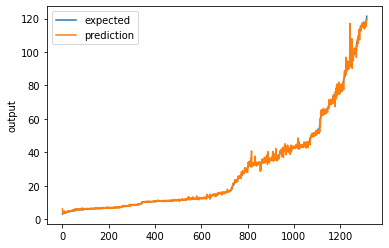

In [ ]:
# Model layer Summary
model2.summary()

print()

# Predict
pred = model2.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Convolutional Neural Networks -- with VALID PADDING")
print()
gplot.chart_regression(pred.flatten(),y_test)

### Configuration 2 : Adam optimizer and padding - same 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_Case1_same.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

startTime = time.time()

for i in range(5):
  model2 = Sequential()
  model2.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="same",
                  activation='relu',
                  input_shape=input_shape)) 
  model2.add(Conv2D(200, (2, 2), padding="same",activation='relu'))
  #model2.add(MaxPooling2D(pool_size=(2, 2)))
  model2.add(Dropout(0.20)) 

  model2.add(Flatten())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dropout(0.20))

  model2.add(Dense(1))
  model2.compile(loss='mean_squared_error', optimizer='adam')
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
  model2.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model2.load_weights(filepath_savemodel)

Epoch 00005: early stopping
Epoch 00009: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Epoch 00011: early stopping
Elapsed time: 368.64138293266296


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 7, 5, 512)         5120      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 7, 5, 200)         409800    
_________________________________________________________________
dropout_68 (Dropout)         (None, 7, 5, 200)         0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 7000)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               896128    
_________________________________________________________________
dropout_69 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)               

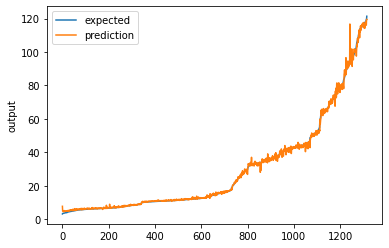

In [ ]:
# Model layer Summary
model2.summary()

# Predict
pred = model2.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Convolutional Neural Networks - Input as 1 Channel")
print()
gplot.chart_regression(pred.flatten(),y_test)

## CASE 2: Each Record as 7 X 1 X 5 (5 channels)

In [ ]:
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = os.path.join(data_path, "P2_Preprocessed_CNN_LSTM.csv")
df = pd.read_csv(filepath, na_values=['NA','?','-'])

print(df.dtypes , df.shape)
print()
print(df[0:5])
print()
print(df.isnull().sum())

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
Output    float64
dtype: object (4392, 6)

       Open      High       Low     Close    Volume    Output
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625

Open      0
High      0
Low       0
Close     0
Volume    0
Output    0
dtype: int64


In [ ]:
y_ch5 = df['Output'].copy() # y is copy of close column
x_ch5 = df.drop(columns=['Output'], axis= 1, inplace=False)

x_ch5 = x_ch5.to_numpy(dtype="float32");
y_ch5 = y_ch5.to_numpy(dtype="float32");
print(x_ch5.shape, y_ch5.shape)

(4392, 5) (4392,)


In [ ]:
import numpy as np

def to_sequences_v2(seq_size, input, target):
    x = []
    y = []

    for i in range(len(input)-seq_size-1):
        window = input[i:(i+seq_size)]
        after_window = target[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [ ]:
# each record is converted into 7X1 array
SEQ_SIZE = 7
x_ch5,y_ch5 = to_sequences_v2(SEQ_SIZE, x_ch5, y_ch5)
print(x_ch5.shape , y_ch5.shape)

(4384, 7, 1, 5) (4384,)


In [ ]:
print(x_ch5[0:2])
print(y_ch5[0:2])

[[[[-8.9420879e-01 -8.8502169e-01 -8.9230639e-01 -8.8436353e-01
     1.1048120e+00]]

  [[-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
    -4.9730068e-01]]

  [[-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
    -8.9221716e-01]]

  [[-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
    -2.6340524e-04]]

  [[-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
     3.7293661e+00]]

  [[-9.0465510e-01 -9.0002036e-01 -9.0496856e-01 -9.0735239e-01
     5.9217567e+00]]

  [[-9.0361047e-01 -9.0415794e-01 -9.1657561e-01 -9.0526253e-01
     6.9392648e+00]]]


 [[[-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
    -4.9730068e-01]]

  [[-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
    -8.9221716e-01]]

  [[-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
    -2.6340524e-04]]

  [[-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
     3.7293661e+00]]

  [[-9.0465510e-01 -9.0002036e-01 -9.0496856e-01 -9.

### Configuration 1 : Adam optimizer and padding - valid 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_ch5, y_ch5, test_size=0.30, random_state=120)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print()
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (3068, 7, 1, 5)
x_test shape: (1316, 7, 1, 5)
y_train shape: (3068,)
y_test shape: (1316,)

Training samples: 3068
Test samples: 1316


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_Case2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

startTime = time.time()

for i in range(5):
  model2 = Sequential()
  model2.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="same",
                  activation='relu',
                  input_shape=input_shape)) 
  model2.add(Conv2D(200, (2, 2), padding="same",activation='relu'))
  #model2.add(MaxPooling2D(pool_size=(2, 2)))
  model2.add(Dropout(0.20)) 

  model2.add(Flatten())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dropout(0.20))

  model2.add(Dense(1))
  model2.compile(loss='mean_squared_error', optimizer='adam')
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
  model2.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model2.load_weights(filepath_savemodel)

Epoch 00012: early stopping
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00009: early stopping
Epoch 00005: early stopping
Elapsed time: 177.79609489440918


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 7, 1, 512)         23552     
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 7, 1, 200)         409800    
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 1, 200)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 1400)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               179328    
_________________________________________________________________
dropout_59 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

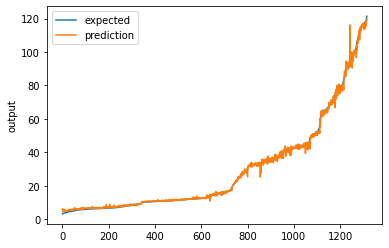

In [ ]:
# Model layer Summary
model2.summary()

print()

# Predict
pred = model2.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Convolutional Neural Networks -- Input as 5 Channels")
print()
gplot.chart_regression(pred.flatten(),y_test)